# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Import Dataset

In [ ]:
data=pd.read_csv("Breast_cancer_data.csv")
data.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


Continous variables are not so good to naive bayes classifier. We need to modify them. 1. Convert them to the categorical features. 2. To fit some approximate distribution to these features so we can calculate these probabilities more easily

# Histograms

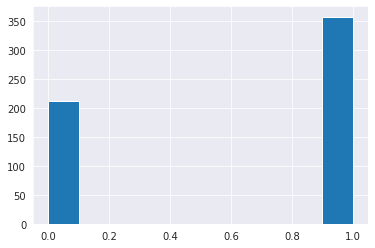

In [ ]:
data["diagnosis"].hist()

Dataset is a bit unbalanced, because there is more "1" diagnosis.
Now we have to check if variables are independent.

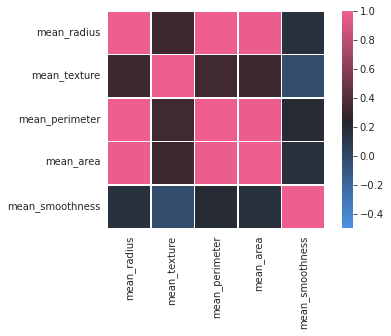

In [ ]:
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center="dark",as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, Linewidths=.2)

Correlation score are high, so variables are dependent on each other. So I will choose mean_radius, mean_texture and mean_smoothness.

In [ ]:
df = data.drop(columns=['mean_perimeter','mean_area'])
df

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,17.99,10.38,0.11840,0
1,20.57,17.77,0.08474,0
2,19.69,21.25,0.10960,0
3,11.42,20.38,0.14250,0
4,20.29,14.34,0.10030,0
...,...,...,...,...
564,21.56,22.39,0.11100,0
565,20.13,28.25,0.09780,0
566,16.60,28.08,0.08455,0
567,20.60,29.33,0.11780,0


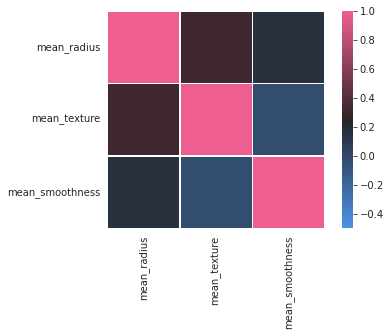

In [ ]:
corr = df.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center="dark",as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, Linewidths=.2)

Now I will build a histogram of each variable to fit a distribution to them.

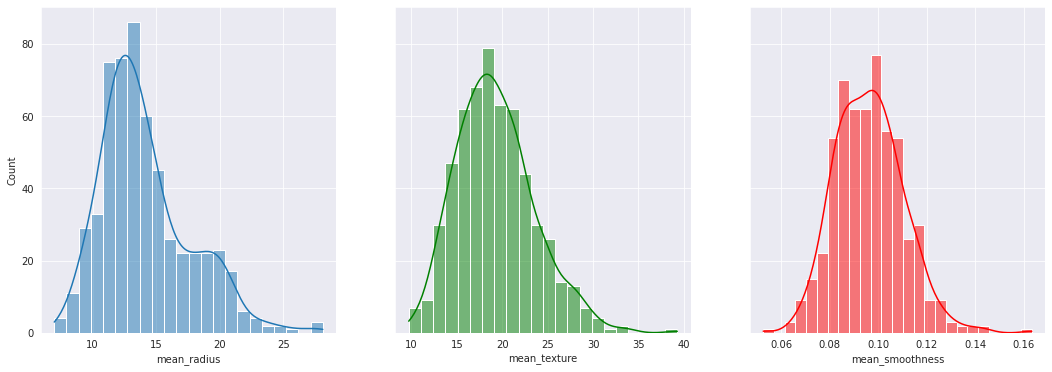

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(18,6), sharey=True)
sns.histplot(data, ax=axes[0], x="mean_radius", kde=True)
sns.histplot(data, ax=axes[1], x="mean_texture", kde=True, color='g')
sns.histplot(data, ax=axes[2], x="mean_smoothness", kde=True, color='r')

2 and 3 - They follows the normal distribution
1 - we will fit a normal distribution

## Calculate P(Y=y)

In [ ]:
def calculate_py(df,Y):
  classes = sorted(list(df[Y].unique()))
  p = []
  for i in classes:
    p.append(len(df[df[Y]==i])/len(df))
  return p

# Calculate P(X=x|Y=y) using Normal distribution

In [ ]:
def calculate_likelihood_normal(df, feature, value,Y, label):
  feat = list(df.columns)
  df = df[df[Y]==label]
  mean = df[feature].mean()
  std = df[feature].std()
  px_y=(1/(std*np.sqrt(2*np.pi)))*np.exp(-(value-mean)**2/(2*std**2))
  return px_y


# Calculate P(X=x1|Y=y)*P(X=x2|Y=y)...*P(X=xn|Y=y)*P(Y=y)

In [ ]:
def naive_bayes(df, X, Y):
  #get feature names
  features= list(df.columns)[:-1]

  #calculater probabililty
  p=calculate_py(df,Y)

  Y_pred=[]
  for x in X:
    labels = sorted(list(df[Y].unique()))
    likelihood=[1]*len(labels)
    for j in range(len(labels)):
      for i in range(len(features)):
        likelihood[j] *= calculate_likelihood_normal(df, features[i], x[i], Y, labels[j])

    post_prob = [1]*len(labels)
    for j in range(len(labels)):
      post_prob[j] = likelihood[j] * p[j]

    Y_pred.append(np.argmax(post_prob))

  return np.array(Y_pred)

# Test

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.3)

X_test = test.iloc[:,:-1].values
Y_test=test.iloc[:,-1].values
y_pred= naive_bayes(train, X=X_test, Y="diagnosis")

0.9344262295081966


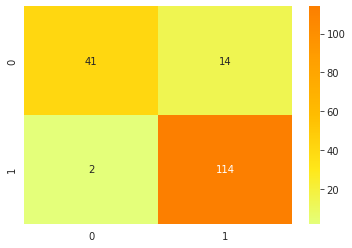

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
# create seabvorn heatmap with required labels
print(f1_score(Y_test, y_pred))
ax = sns.heatmap(confusion_matrix(Y_test, y_pred),cmap="Wistia",xticklabels=data["diagnosis"].unique(), yticklabels=data["diagnosis"].unique(),annot=True,fmt="d")

The result is show in the confusion matrix. Only 16 records from the test data were wrongly classified. The f1-score is equal 0.93. 
